In [5]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
from cudams.utils import use_style

use_style()

# Plots concerning performance

rtx3090 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
colab_t4 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
rtx4090 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
cpu_matchms dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])


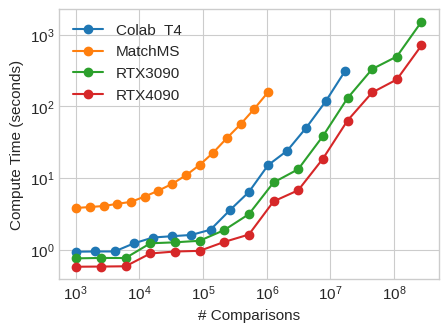

In [11]:
data = []
for nb in Path('notebooks/performance/').glob('*.ipynb'):
    if 'generate' in nb.stem: continue
    method = nb.stem.split('_on_')[-1]
    proper_label = dict(
        colab_t4='Colab  T4',
        cpu_matchms='MatchMS',
        rtx4090='RTX4090',
        rtx3090='RTX3090',
    )
    nb = json.loads(nb.read_text())
    print(method, nb.keys())
    # try:
    res = json.loads(' '.join(nb['cells'][-1]['outputs'][0]['text']))
    # except:
    #     print("AAAAAAAAAAAAAAAAA")
    #     print(' '.join(nb['cells'][-1]['outputs'][0]['text']))
    #     raise
    # continue
    res['method'] = method
    res['pairs'] = res.get('pairs_cu', res.get('pairs'))
    res['times'] = res.get('times_cu', res.get('times'))

    try:
        res.pop('pairs_cu')
    except:
        pass
    try:
        res.pop('times_cu')
    except:
        pass

    for r in range(len(res['pairs'])):
        if 'cpu' in method:
            res['device'] = 'v32CPU'
        data.append(dict(
            pairs=res['pairs'][r],
            times=res['times'][r],
            device=res['device'],
            nproc=res['nproc'],
            method=method
        ))

# Since experiments were done in different scales
# to save time, 
df = pd.DataFrame(data)
pairs_scale = np.logspace(np.log2(df.pairs.min()), 
                          np.log2(df.pairs.max()),
                          base=2,
                          dtype='float64',
                          num=50)

plt.figure()
# plt.gca().set_prop_cycle(color=['red', 'red', 
#                                 'green', 'green', 
#                                 'blue',  'blue'])
for i, (name, gr) in enumerate(df.groupby('method')):
    # display(gr)
    # f = np.polyfit(gr.pairs, gr.times, 2, rcond=.01) # Should be linear, roughly
    # interp_times = np.poly1d(f)(pairs_scale)
    # c = np.random.rand(3,)
    plt.loglog(gr.pairs, gr.times, '-o', label=proper_label[name])
    
    # plt.loglog(pairs_scale, interp_times, label=name, )
plt.xlabel("# Comparisons")
plt.ylabel("Compute Time (seconds)")
plt.legend()
plt.show()